# Analysis of Proportional-Integral Controller

## Learning Objectives

In this notebook, we will use a mathematical model for the TCLab to design and analyze a PI controller.

After studying this notebook and completing the activities, you will be able to:
* Agument dynamic system model with PI feedback control law to predict closed loop dynamics
* Analyze stability of a (linear) system
* Perform senstivity analysis to tune controller

First review the [proportional only controller notes](./P-Controller-Analysis.ipynb) for modeling details.


In [2]:
# Set default parameters for publication quality plots
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

## Proporational-Integral Control Law

We will consider the proporational control law:

$$
u_{1}(t) = \bar{u}_{1} + K_P (T_{set} - T_{S,1}(t)) + K_I \int_{0}^{t} (T_{set} - T_{S,1}(t')) dt'
$$

Here, $K_P > 0$ is the proportional gain, $K_I > 0$ is the integral gain, and $e(t) = T_{set} - T_{S,1}(t)$ is the tracking error. For the purposes of stability analysis, we will consider a constant $T_{set}$.


## Closed-Loop Dynamics


How can we model the integral in the control law? Let's add a new state to our model for the integral:

\begin{align}
C^H_p\frac{dT^*_{H,1}}{dt} & = -U_a T^*_{H,1} + U_b(T^*_{S,1} - T^*_{H,1}) - \alpha P_1 K_P (T^*_{S,1} - T^*_{set}) + \alpha P_1 K_I I\\
C^S_p\frac{dT^*_{S,1}}{dt} & = U_b(T^*_{H,1} - T^*_{S,1}) \\
\frac{dI}{dt} &= T^*_{set}-T^{*}_{S,1}
\end{align}

We are defining the deviation variables relative to the ambient temperature.

Let's collect similar terms:

\begin{align}
\frac{dT^*_{H,1}}{dt} & = \left(-\frac{U_a + U_b}{C^H_p} \right)  T^*_{H,1} + \left(\frac{U_b - \alpha P_1 K_p}{C_p^H} \right) T^*_{S,1} + \left(\frac{- \alpha P_1 K_I}{C_p^H} \right) I + \frac{\alpha P_1 K_P}{C^H_p} T^*_{set} \\
\frac{dT^*_{S,1}}{dt} & = \left(\frac{U_b}{C_p^S} \right) T^*_{H,1} + \left(-\frac{U_b}{C_p^S} \right) T^*_{S,1} \\
\frac{dI}{dt} &= -T^{*}_{S,1}
\end{align}


Finally, we can write this as a linear differential equation in matrix form:

\begin{align}
\frac{d}{dt}\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x} & = 
\underbrace{\begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b - \alpha P_1 K_P}{C^H_p} & \frac{\alpha P_1 K_I}{C^H_p} \\ 
\frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p} & 0 \\
0 & -1 & 0 \end{bmatrix}}_\mathbf{A} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x} + \underbrace{\begin{bmatrix} \frac{\alpha P_1 K_P}{C^H_p} \\ 0 \\ 1 \end{bmatrix}}_{\mathbf{B}} \underbrace{\begin{bmatrix} T^*_{set} \end{bmatrix}}_{\mathbf{u}} \\
\\
\underbrace{\begin{bmatrix} T^*_{S,1}\end{bmatrix}}_\mathbf{y} & = 
\underbrace{\begin{bmatrix}0 & 1 & 0 \end{bmatrix}}_\mathbf{C} 
\underbrace{\begin{bmatrix} T^*_{H,1} \\ T^*_{S,1} \\ I \end{bmatrix}}_\mathbf{x}
\end{align}

If we derivate the system with the deviation terms relative to the setpoint, we get the same $\mathbf{A}$ matrix.

## Numeric Simulation 

### Closed Loop Continuous

Let's simulate the closed loop response.

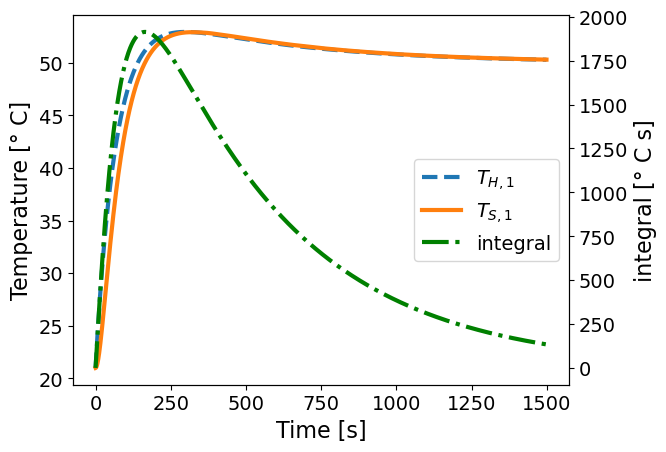

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# parameters
T_amb = 21 # deg C
alpha = 0.00016 # watts / (units P1 * percent U1)
P1 = 100 # P1 units
U1 = 50 # steady state value of u1 (percent)

# fitted parameters (see previous lab) for hardware
'''
Ua = 0.0261 # watts/deg C
Ub = 0.0222 # watts/deg C
CpH = 1.335 # joules/deg C
CpS = 1.328 # joules/deg C
'''

# fitted parameters (repeat Lab 3) for TCLab digital twin
Ua = 0.05 # watts/deg C
Ub = 0.05 # watts/deg C
CpH = 5.0 # joules/deg C
CpS = 1.0 # joules/deg C

t_final = 1500
t_step = 1
t_expt = np.arange(0,t_final,t_step)


T_set = 50

def simulate_response(Kp=2.0, Ki=0.1):
    """ Simulate the response of the system to a step change in setpoint 
    (initialized at ambient temperature) with a PI controller.
    
    Arguments:
        Kp: proportional gain
        Ki: integral gain

    Returns:
        Nothing

    Actions:
        Plots the response of the system

    """
    A_PI = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, -1, 0]])


    
    def deriv3(t, y):
        ''' RHS of ODE for system dynamics

        Arguments:
        t: time
        y: state vector [T_H1, T_S1, integral]
        
        '''

        return A_PI @ y
    
    # Initial point: ambient temperature, I = 0
    soln_P = solve_ivp(deriv3, [min(t_expt), max(t_expt)], [T_amb - T_set, T_amb-T_set, 0], t_eval=t_expt)

    # Create axes for xyy plot
    fig, ax1 = plt.subplots()

    # Plot temperatures on left axis
    ax1.plot(soln_P.t, soln_P.y[0] + T_set,label='$T_{H,1}$', linestyle='--')
    ax1.plot(soln_P.t, soln_P.y[1] + T_set,label='$T_{S,1}$', linestyle='-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Temperature [° C]')

    # Plot the integral on the right axis
    ax2 = ax1.twinx()
    ax2.plot(soln_P.t, soln_P.y[2] ,label='integral', color='green', linestyle='-.')
    ax2.set_ylabel('integral [° C s]')

    # Add legend
    #fig.legend(['T1H','T1S','integral'])
    fig.legend(bbox_to_anchor=(0.9, 0.6))
    plt.show()

simulate_response(Kp=2.5, Ki=0.01)

Perform a simple sensitivity analysis and answer the following discussion questions:
* What happens with small and large $K_P$ values? Does the solution overshoot or undershoot? How long does it take to reach the set point?
* What happens with small and large $K_I$ values?

### Digital Control (Discrete Model)

In [4]:
from scipy.signal import cont2discrete

def continuous_system(Kp, Ki):
    ''' Continous system for TCLab with PI control

    Arguments:
        Kp: the proportional control gain
        Ki: the integral control gain
        
    Returns:
        A, B, C, D: the state space matrices

    '''

    A = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, -1, 0]])

    B = np.array([[alpha*P1*Kp/CpH], [0], [1]])

    C = np.array([[0, 1, 0]])

    D = np.array([[0]])

    return A, B, C, D

def discrete_system(Kp, Ki):
    ''' Discrete system for TCLab with PI control

    Arguments:
        Kp: the proportional control gain

    Returns:
        Ad, Bd, Cd, Dd: the state space matrices

    Notes:
        The time step is assumed to be 1 second

    '''
    A, B, C, D = continuous_system(Kp, Ki)

    d_system = cont2discrete((A, B, C, D), 1, method='zoh')

    # Extract the discrete time A and B matrices
    Ad = d_system[0]
    Bd = d_system[1]
    Cd = d_system[2]
    Dd = d_system[3]

    return Ad, Bd, Cd, Dd

Ad, Bd, Cd, Dd = discrete_system(Kp=1.0, Ki= 0.1)
print("Ad=\n",Ad)
print("Bd=\n",Bd)
print("Cd=\n",Cd)
print("Dd=\n",Dd)

Ad=
 [[ 9.80361050e-01  6.41040825e-03  3.16838748e-04]
 [ 4.82847849e-02  9.51390179e-01  7.81612483e-06]
 [-2.44253901e-02 -9.75465854e-01  9.99997379e-01]]
Bd=
 [[3.32733054e-03]
 [8.07818077e-05]
 [9.99973137e-01]]
Cd=
 [[0 1 0]]
Dd=
 [[0]]


Next, let's consider the system responding to a setpoint starting at 5C above ambient and then increasing to 430C above ambient at 100 seconds.

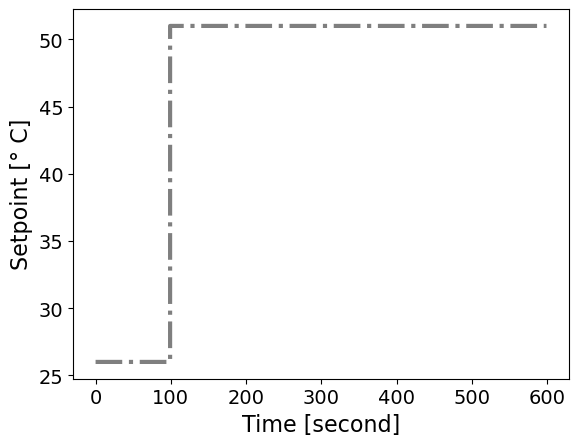

In [5]:
t = np.arange(0, 600, 1)
T_set = np.ones(t.shape)*5
T_set[100:] = 30

plt.step(t, T_set + T_amb, linestyle='-.', color='black', alpha=0.5)
plt.xlabel('Time [second]')
plt.ylabel('Setpoint [° C]')
plt.show()


Next, let's simulate the response of the continous system.

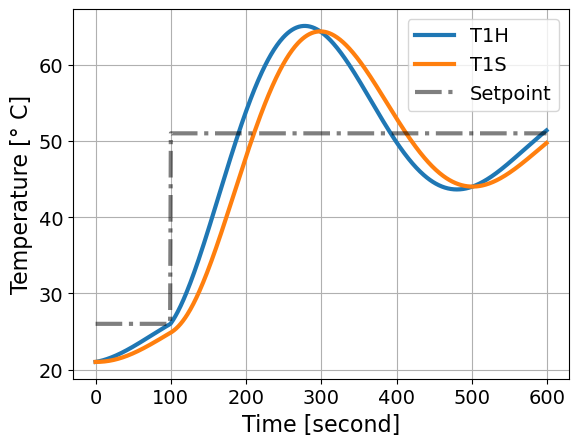

In [6]:
from scipy.signal import lsim, lti

def simulate_response_continous(Kp=1.0, Ki = 0.1):

    c_system = lti(*continuous_system(Kp, Ki))

    T, yout, xout = lsim(c_system, T_set, t, X0=[0, 0, 0])

    plt.plot(t, xout[:,0] + T_amb, label='T1H')
    plt.plot(t, xout[:,1] + T_amb, label='T1S')
    plt.plot(t, T_set + T_amb, label='Setpoint', linestyle='-.', color='black', alpha=0.5)
    plt.xlabel('Time [second]')
    plt.ylabel('Temperature [° C]')
    plt.grid()
    plt.legend()
    plt.show()

simulate_response_continous(Kp=1.0, Ki=0.1)

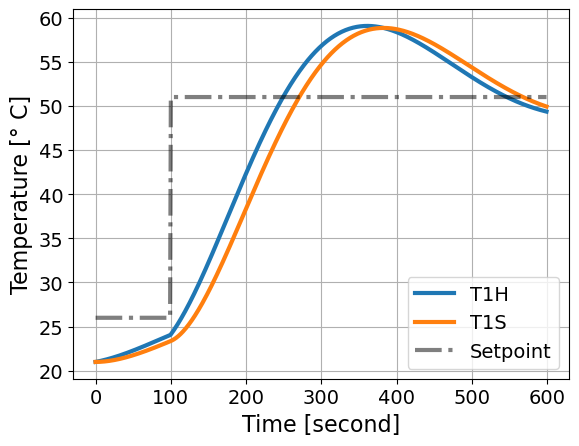

In [7]:
simulate_response_continous(Kp=1.0, Ki=0.05)

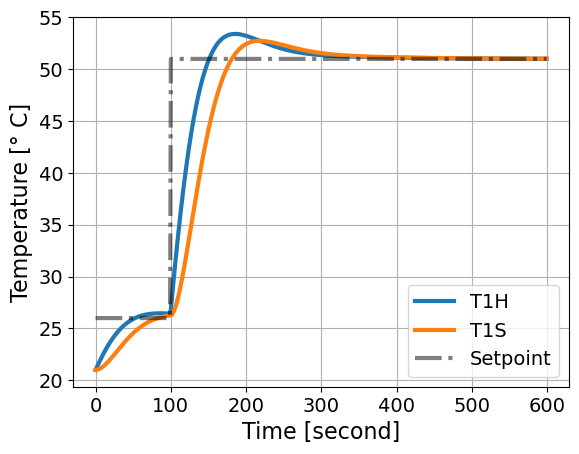

In [8]:
simulate_response_continous(Kp=10.0, Ki=0.1)

Next, let's simulate the discrete time system.

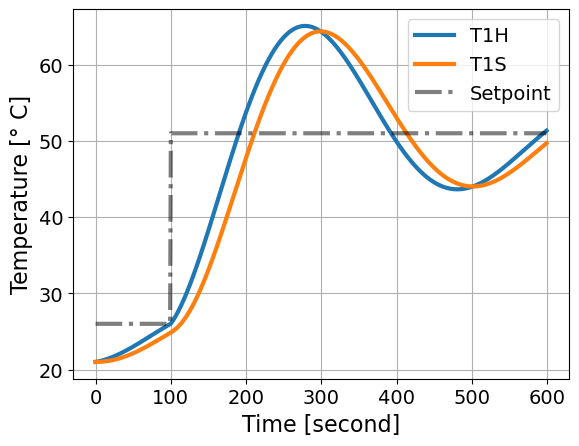

In [9]:
from scipy.signal import dlti, dlsim

def simulate_response_discrete(Kp=1.0, Ki = 0.1):

    d_system = dlti(*discrete_system(Kp, Ki))

    T, yout, xout = dlsim(d_system, T_set, t)

    plt.plot(t, xout[:,0] + T_amb, label='T1H')
    plt.plot(t, xout[:,1] + T_amb, label='T1S')
    plt.plot(t, T_set + T_amb, label='Setpoint', linestyle='-.', color='black', alpha=0.5)
    plt.xlabel('Time [second]')
    plt.ylabel('Temperature [° C]')
    plt.grid()
    plt.legend()
    plt.show()

simulate_response_discrete(Kp=1.0, Ki=0.1)

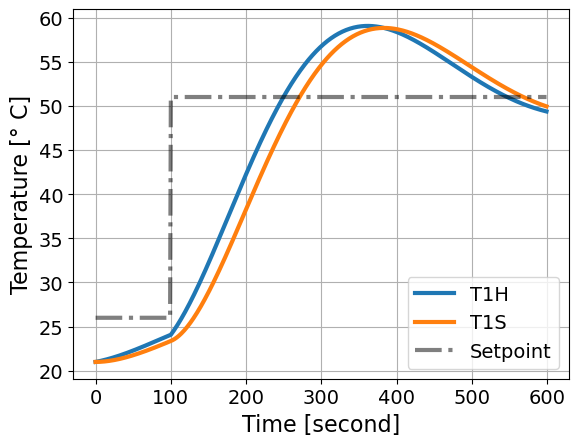

In [10]:
simulate_response_discrete(Kp=1.0, Ki=0.05)

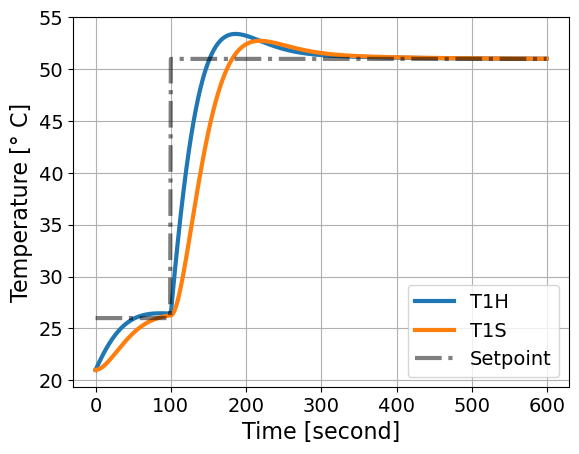

In [11]:
simulate_response_discrete(Kp=10.0, Ki=0.1)

Finally, we can simulate the response using the difference equation and implementing the control logic ourselves.

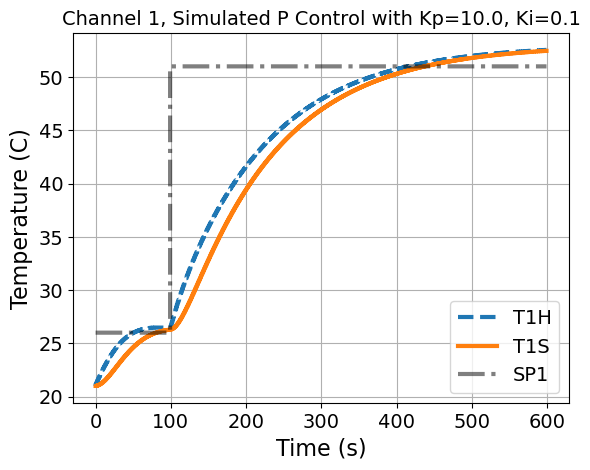

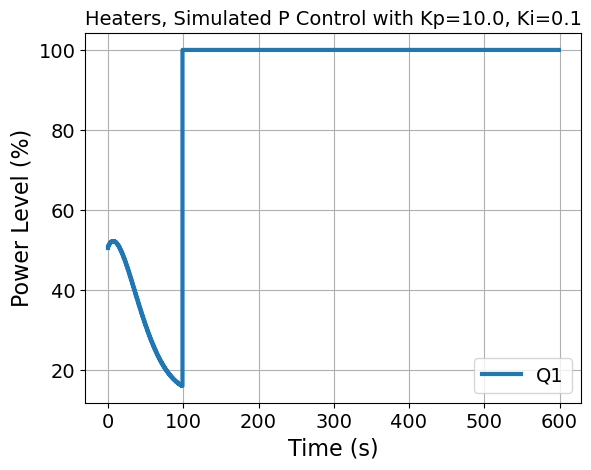

,T1H,T1S,Time,Q1,SP1
0,21.000000,21.000000,0,50.500000,26.0
1,21.160008,21.003947,1,50.960133,26.0
2,21.318382,21.015465,2,51.343409,26.0
3,21.474985,21.034101,3,51.653639,26.0
4,21.629687,21.059419,4,51.894521,26.0
...,...,...,...,...,...
595,52.528971,52.438260,595,100.000000,51.0
596,52.532759,52.442777,596,100.000000,51.0
597,52.536517,52.447258,597,100.000000,51.0
598,52.540244,52.451703,598,100.000000,51.0


In [12]:
import pandas as pd


def tclab_simulate_PI(Kp = 1.0, Ki = 0.1, verbose=False, plot=True):
    ''' Simulate the TCLab system with PI control
    Arguments:
        Kp: the proportional control gain
        Ki: the integral control gain
        verbose: print matrices, default is False
        plot: create plots, default is True

    Returns:
        data: DataFrame with columns for Time, T1, T2, Q1, Q2
    '''

    n = len(t)

    assert len(T_set) == n, 'Setpoint array must have the same length as time array'

    # Original open loop state space model
    A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
    B = np.array([[alpha*P1/CpH], [0]])
    C = np.array([[0, 1]])
    D = np.array([[0]])

    Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), dt=1, method='zoh')

    # Initialize state matrix
    X = np.zeros((n, 2))

    # Initialize input matrix
    U = np.zeros((n, 1))

    # Initialize the integral term
    integral = 0

    # Loop over time steps
    for i in range(n):
        # Current state
        x = X[i, :]

        # Unpack into individual states
        T1H, T1S = x

        # Integrate the error
        integral += (T_set[i] - T1S)

        # Temperature control
        # Channel 1
        # Hint: Write code below to set U[i,0]
        # Look at the equations you wrote down for the relay controller
        U[i, 0] = Kp*(T_set[i] - T1S) + Ki*integral

        # Limit the power levels
        U[i, 0] = max(0, min(100, U[i, 0]))

        # Update state
        if i < n-1:
            # Do not update the state for the last time step
            # We want to update U and SP for plotting
            X[i + 1, :] = Ad @ x + Bd @ U[i, :]


    # Shift states from deviation variables to absolute values
    X += T_amb

    # Create DataFrame
    data = pd.DataFrame(X, columns=['T1H', 'T1S'])
    data['Time'] = t
    data['Q1'] = U[:, 0]
    data['SP1'] = T_set + T_amb

    if plot:
        plt.title('Channel 1, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['T1H'], label='T1H', linestyle='--')
        plt.step(data['Time'], data['T1S'], label='T1S', linestyle='-')
        plt.step(data['Time'], data['SP1'], label='SP1', linestyle='-.', color='black', alpha=0.5)
        plt.ylabel('Temperature (C)')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.grid()
        plt.show()
        

        plt.title('Heaters, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['Q1'], label='Q1')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Level (%)')
        plt.legend()
        plt.grid()
        plt.show()

    return data

tclab_simulate_PI(Kp=10.0, Ki=0.1)

## Stability Analysis

### Continuous LTI System

Let's inspect the eigenvalues of $\mathbf{A}$.

In [13]:
# Eigendecomposition analysis
from scipy.linalg import eig

def calc_eig(Kp,Ki,verbose=True):

    A_PI = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, -alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, 1, 0]])
    
    w, vl = eig(A_PI)

    if verbose:
        for i in range(len(w)):
            print("Eigenvalue",i,"=",w[i])
            print("Eigenvector",i,"=",vl[:,i],"\n")

    return w

calc_eig(Kp=1.5,Ki=0.01)

Eigenvalue 0 = (-0.05764412757011409+0j)
Eigenvector 0 = [ 0.00879784 -0.05754637  0.99830407] 

Eigenvalue 1 = (-0.00940444864546306+0j)
Eigenvector 1 = [ 0.00763502  0.00940376 -0.99992664] 

Eigenvalue 2 = (-0.002951423784422808+0j)
Eigenvector 2 = [-0.00277718 -0.0029514   0.99999179] 



array([-0.05764413+0.j, -0.00940445+0.j, -0.00295142+0.j])

Here are rules for interpretting the eigenvalues and eigenvectors:
* If all of the real components of the eigenvalues are negative, the system is stable and will return to the steady state ($T^*_{S,1} \rightarrow 0$, $T^*_{H,1} \rightarrow 0$).
* The eigenvectors corresponding to any eigenvalues with a positive real component shows the direction of exponential growth.
* If any of the eigenvalues have non-zero imaginary components, the system osciallates.

Let's perform a sensitivity analysis to see how the eigenvalues change.

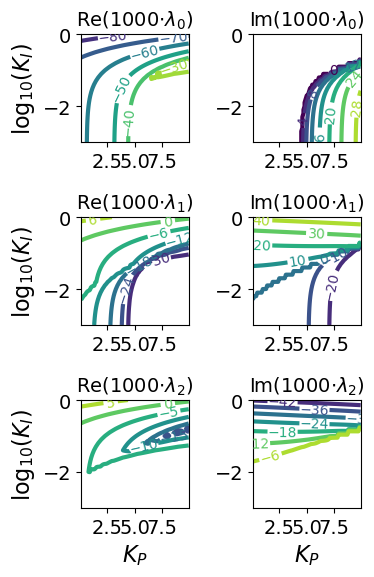

In [14]:
Kp_range = np.arange(0.1,10,0.1)
Ki_range = np.arange(-3,0.1,0.1)
xv, yv = np.meshgrid(Kp_range, Ki_range)

# store eigenvalues in 3D array
s3 = (len(Ki_range),len(Kp_range),3)
s2 = (len(Ki_range),len(Kp_range))
ev = np.zeros(s3, dtype=complex)
positive_real_eig = np.zeros(s2)
nonzero_imag_eig = np.zeros(s2)

small_number = 1E-9

for i in range(len(Ki_range)):
    for j in range(len(Kp_range)):
        ev[i,j,:] = calc_eig(xv[i,j], np.power(10,yv[i,j]), verbose=False)[:]
        positive_real_eig[i,j] = sum(np.real(ev[i,j,:]) >= -small_number)
        nonzero_imag_eig[i,j] = sum(np.abs(np.imag(ev[i,j,:])) >= small_number)


fig, axs = plt.subplots(3,2)
fig.set_figheight(6)
fig.set_figwidth(4)


scale = 1000

# Loop over eigenvalues (rows)
for i in range(3):

    # Plot contour of real component
    CS = axs[i,0].contour(xv,yv,np.real(ev[:,:,i])*scale)
    axs[i,0].set_box_aspect(1)
    axs[i, 0].clabel(CS, inline=True, fontsize=10)
    axs[i, 0].set_title('Re(' + str(scale) + '$\cdot \lambda_'+str(i)+'$)')
    axs[i, 0].set_ylabel('log$_{10}$($K_I$)')

    # Plot contour of imaginary component
    CS = axs[i,1].contour(xv,yv,np.imag(ev[:,:,i])*scale)
    axs[i,1].set_box_aspect(1)
    axs[i, 1].clabel(CS, inline=True, fontsize=10)
    axs[i, 1].set_title('Im(' + str(scale) + '$\cdot \lambda_'+str(i)+'$)')
    
    # Bottom row: add labels to x-axis
    if i == 2:
        axs[i, 0].set_xlabel('$K_P$')
        axs[i, 1].set_xlabel('$K_P$')

plt.tight_layout()
plt.show()



These six subplots show how the real (right) and imaginary (left) components of the three eigenvalues (rows) change as a function of $K_P$ and $K_I$. While these plots are informative, they are a little difficult to interpret.

The code below plots the number of positive real eigenvalue componenets (left) and nonzero imaginary eigenvalue components (right). **Yellow regions are 2** and **blue regions are 0**. Thus, choosing $K_P$ and $K_I$ values in the blue region on the left ensures the controller is stable. Likewise, selecting the blue region on the right ensures no oscillations. The exact region of these transitions depends on our assumptions about the mathematical model (and measurement noise). We are hoping the model is good enough to use this plot as a guideline for tuning the controller.

<Figure size 640x480 with 0 Axes>

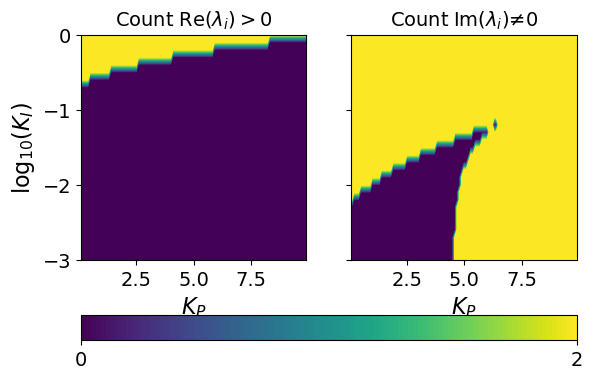

In [15]:
plt.figure()
fig, axs = plt.subplots(1,2, sharey=True)

axs[0].set_box_aspect(1)
cs = axs[0].contourf(xv,yv,positive_real_eig, levels=100)
axs[0].set_xlabel('$K_P$')
axs[0].set_ylabel('log$_{10}$($K_I$)')
axs[0].set_title('Count Re($\lambda_i$)$>0$')

axs[1].set_box_aspect(1)
cs = axs[1].contourf(xv,yv,nonzero_imag_eig, levels=100)

axs[1].set_xlabel('$K_P$')
#axs[1].set_ylabel('log$_{10}$($K_i$)')
axs[1].set_title('Count Im($\lambda_i$)$≠0$')


cbar = fig.colorbar(cs, ticks=[0, 2], orientation='horizontal', ax=axs[:])

#plt.tight_layout()
#plt.savefig('PI_stability.pdf')
plt.show()

This is the plot you should reproduce and interpret in [](../../assignments/Lab-4-PI-Control.ipynb).

### Discrete LTI System

We can also analyze the eigenvalues of $\mathbf{A}_d$

In [16]:
def calc_eig_discrete(Kp,Ki,verbose=True):

    A_PI = np.array([[-(Ua + Ub)/CpH, (Ub - alpha*P1*Kp)/CpH, -alpha*P1*Ki/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [0, 1, 0]])
    
    A_d, B_d, C_d, D_d, dt = cont2discrete((A_PI, np.zeros((3,1)), np.eye(3), np.zeros((3,1))), dt=1, method='zoh')

    w, vl = eig(A_d)

    if verbose:
        for i in range(len(w)):
            print("Eigenvalue",i,"=",w[i])
            print("Eigenvector",i,"=",vl[:,i],"\n")

    return w

calc_eig_discrete(Kp=1.5,Ki=0.01)

Eigenvalue 0 = (0.9970529273850182+0j)
Eigenvector 0 = [-0.00277718 -0.0029514   0.99999179] 

Eigenvalue 1 = (0.9906396348796779+0j)
Eigenvector 1 = [-0.00763502 -0.00940376  0.99992664] 

Eigenvalue 2 = (0.943985826198011+0j)
Eigenvector 2 = [-0.00879784  0.05754637 -0.99830407] 



array([0.99705293+0.j, 0.99063963+0.j, 0.94398583+0.j])

<Figure size 640x480 with 0 Axes>

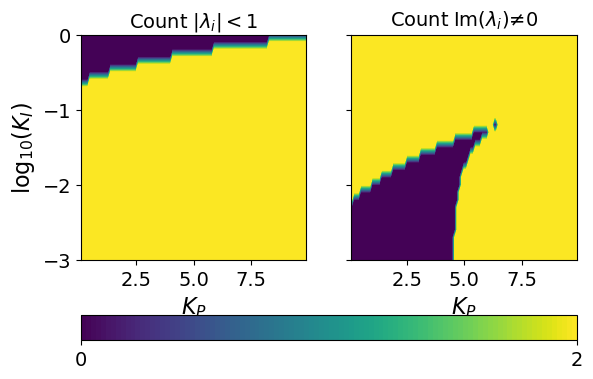

In [17]:
Kp_range = np.arange(0.1,10,0.1)
Ki_range = np.arange(-3,0.1,0.1)
xv, yv = np.meshgrid(Kp_range, Ki_range)

# store eigenvalues in 3D array
s3 = (len(Ki_range),len(Kp_range),3)
s2 = (len(Ki_range),len(Kp_range))
ev = np.zeros(s3, dtype=complex)
positive_real_eig = np.zeros(s2)
nonzero_imag_eig = np.zeros(s2)
within_unit_circle = np.zeros(s2)

small_number = 1E-9

for i in range(len(Ki_range)):
    for j in range(len(Kp_range)):
        ev[i,j,:] = calc_eig_discrete(xv[i,j], np.power(10,yv[i,j]), verbose=False)[:]
        positive_real_eig[i,j] = sum(np.real(ev[i,j,:]) >= -small_number)
        nonzero_imag_eig[i,j] = sum(np.abs(np.imag(ev[i,j,:])) >= small_number)
        within_unit_circle[i,j] = sum(np.abs(ev[i,j,:]) <= 1+small_number)

plt.figure()
fig, axs = plt.subplots(1,2, sharey=True)

axs[0].set_box_aspect(1)
cs = axs[0].contourf(xv,yv,within_unit_circle, levels=100)
axs[0].set_xlabel('$K_P$')
axs[0].set_ylabel('log$_{10}$($K_I$)')
axs[0].set_title('Count $|\lambda_i|<1$')

axs[1].set_box_aspect(1)
cs = axs[1].contourf(xv,yv,nonzero_imag_eig, levels=100)

axs[1].set_xlabel('$K_P$')
#axs[1].set_ylabel('log$_{10}$($K_i$)')
axs[1].set_title('Count Im($\lambda_i$)$≠0$')


cbar = fig.colorbar(cs, ticks=[0, 2], orientation='horizontal', ax=axs[:])

#plt.tight_layout()
#plt.savefig('PI_stability.pdf')
plt.show()

## Simulate Performance with TC Lab

In [18]:
%matplotlib inline
from tclab import setup, clock, Historian, Plotter

def simulate_PI_response(Kp=2.0, Ki=0.1):
    """ Simulate a position form PI controller with the
    TCLab digital twin.

    This implementation contains a naive anti-windup for 
    position form. For our class, we will focus on velocity
    form. This example shows position form to complete the website.

    Arguments:
        Kp: proportional gain
        Ki: integral gain
    
    Returns:
        Nothing

    Actions:
        Performs simulation and plots the results
    
    """

    def PI_naive(Kp=4, Ki=0.01, MV_bar=0, antiwindup=True):
        """ Basic proportional-integral controller 

        Arguments:
            Kp: proportional gain
            MV_bar: steady-state value for manipulated variable

        """
        # Minimum and maximum bounds for manipulated variables
        MV_min = 0
        MV_max = 100

        # Initialize with MV_bar
        MV = MV_bar

        # Initialize integral
        I = 0

        # Set limits for integral windup protection
        I_max = 100
        I_min = -100

        while True:
            t_step, SP, PV, MV = yield MV
            e = PV - SP # calculate error
            I += t_step*e # apply integral
            if antiwindup:
                I = max(I_min, min(I_max, I)) # Apply bounds to prevent integral wind-up
            MV = MV_bar - Kp*e - Ki*I # Apply control law
            MV = max(MV_min, min(MV_max, MV)) # Apply manipulated variable upper and lower bounds

    # Initialize in simulation mode
    TCLab = setup(connected=False, speedup = 20)

    SP = 40 # set point, deg C
    tfinal = 600 # simulation horizon, seconds
    t_step = 1 # time step, seconds
    u_star = Ua*(SP-T_amb) / (alpha*100) # u at steady-state
    print("MV_bar =",u_star)

    # create control loop
    controller1 = PI_naive(Kp, Ki, MV_bar=u_star)
    controller1.send(None)

    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, tfinal)
        for t in clock(tfinal, t_step):
            PV = lab.T1                                     # measure the the process variable
            MV = lab.U1                                     # get manipulated variable
            MV = controller1.send([t_step, SP, PV, MV])     # PI control to determine the MV
            lab.Q1(MV)                                      # set the heater power
            p.update()                                      # log data

    plt.show()

### Large Gains: $K_P = 8$ and $K_I = 0.1$

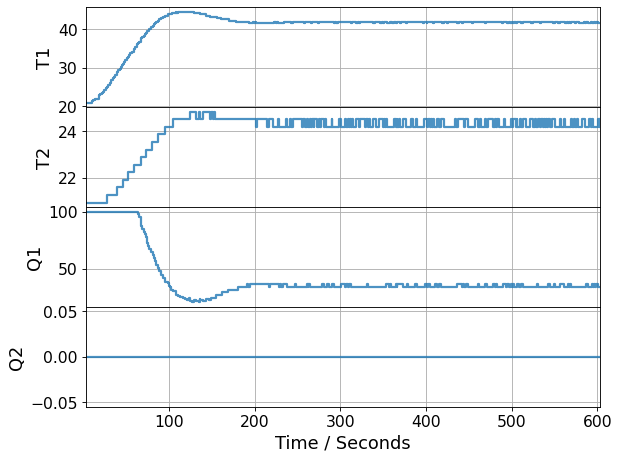

TCLab Model disconnected successfully.


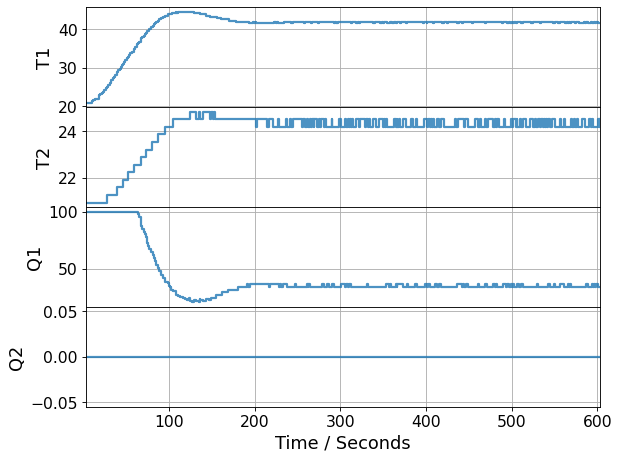

In [19]:
simulate_PI_response(Kp=8, Ki=0.1)

### Small Gains: $K_P = 4$ and $K_I = 0.01$

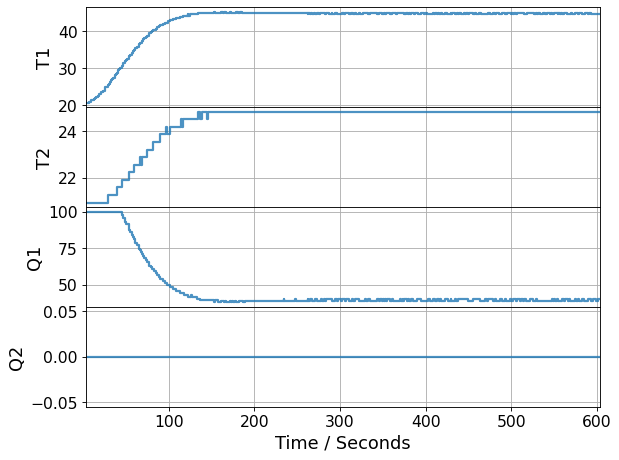

TCLab Model disconnected successfully.


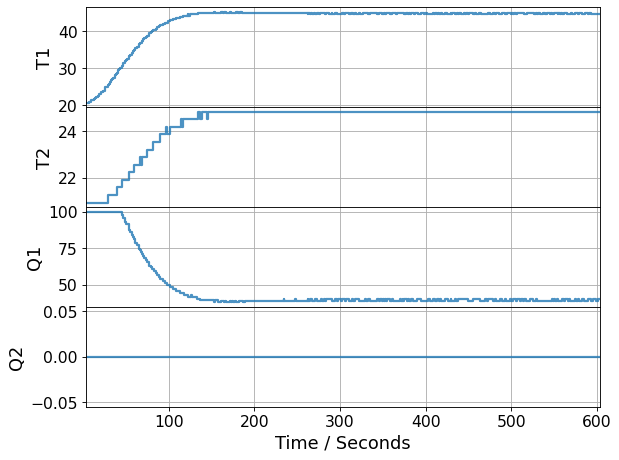

In [20]:
simulate_PI_response(Kp = 4, Ki=0.01)